In [ ]:
!pip install "numpy<2.0" "transformers==4.30.2" --force-reinstall --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.0/763.0 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# ✅ Now run this AFTER restarting runtime
import numpy as np

print("NumPy version:", np.__version__)  # should be <2.0

NumPy version: 1.26.4


# **Drug–Target Interaction Prediction**

Welcome to this tutorial on drug–target interaction (DTI) prediction using the **PyKale library**.

**PyKale** is a Python toolkit that helps make machine learning more approachable, especially for researchers working in interdisciplinary fields. It is particularly useful when dealing with **multimodal data**, which simply means combining different types of data — for example, information about drugs and proteins — to learn patterns from them together.

Even if you’re new to Python or machine learning, don’t worry — we’ll explain key concepts as we go.

&nbsp;

---

&nbsp;

This tutorial builds on the work of [**Bai et al. (_Nature Machine Intelligence_, 2023)**](https://www.nature.com/articles/s42256-022-00605-1), which introduced the **DrugBAN** framework. The DrugBAN includes two key ideas:

- A **bilinear attention network (BAN)**. This is a model that learns the features of both the drug and the protein, and how these features interact locally.


- **Adversarial domain adaptation**. This is a method that helps the model generalise to data that is different from what it was trained on (also known as out-of-distribution data), improving its performance on unseen drug–target pairs.

&nbsp;

---


&nbsp;

## 🔍 What You'll Learn

In the sections that follow, we’ll guide you through the PyKale development pipeline. Specifically, you will learn how to use PyKale to:

- Load and preprocess the data

- Set up the model and the training process

- Train and test the model

Finally, we will compare the results from DrugBAN with those from other established models.

Let’s get started!


## Setup

To begin, we will install the necessary packages required for this tutorial. To maintain clarity and focus on interpretation, we will also suppress any warnings.

In [ ]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

[Optional] If you are using Google Colab, please using the following codes to load necessary demo data and code files.

In [ ]:
!git clone --branch drug-target-interaction https://github.com/pykale/embc-mmai25.git
%cd /content/embc-mmai25/tutorials/drug-target-interaction

Cloning into 'embc-mmai25'...
remote: Enumerating objects: 1165, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 1165 (delta 87), reused 119 (delta 54), pack-reused 979 (from 1)
Receiving objects: 100% (1165/1165), 128.89 MiB | 34.22 MiB/s, done.
Resolving deltas: 100% (543/543), done.
/content/embc-mmai25/tutorials/drug-target-interaction


In [ ]:
from google.colab import drive

drive.mount("/content/drive")

shared_drives_path = (
    "/content/drive/Shared drives/EMBC-MMAI 25 Workshop/data/drug-target-interaction"
)

import os
import shutil

print("Contents of the folder:")
for item in os.listdir(shared_drives_path):
    print(item)

Mounted at /content/drive
Contents of the folder:
bindingdb
biosnap


### 📦 Packages

The main packages required for this tutorial are **PyKale**, **PyTorch Geometric**, and **RDKit**.

- **PyKale** is an open-source interdisciplinary machine learning library developed at the University of Sheffield, designed for applications in biomedical and scientific domains.
- **PyG** (PyTorch Geometric) is a library built on top of PyTorch for building and training Graph Neural Networks (GNNs) on structured data.
- **RDKit** is a cheminformatics toolkit for handling and processing molecular structures, particularly useful for working with SMILES strings and molecular graphs.

Other dependencies are listed in [`embc-mmai25/requirements.txt`](https://github.com/pykale/embc-mmai25/blob/main/requirements.txt).


In [ ]:
!pip install --quiet git+https://github.com/pykale/pykale@main\
    && echo "PyKale installed successfully ✅" \
    || echo "Failed to install PyKale ❌"

!pip install --quiet -r /content/embc-mmai25/requirements.txt \
    && echo "Required packages installed successfully ✅" \
    || echo "Failed to install required packages ❌"

import torch
os.environ['TORCH'] = torch.__version__
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"

!pip install rdkit-pypi \
    && echo "PyG installed successfully ✅" \
    || echo "Failed to install PyG ❌"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/

### ⚙️ Configuration

Before running any model or data processing, we need to tell the code **what settings to use**. To make this easier, we provide a file called `config.py`. Think of this file as a **menu of default settings** that the rest of the code can refer to — for example, where to find the data, which model to use, and how many times to train it.

You can find `config.py` in the same folder as this notebook. You don’t need to change it directly. Instead, we use a **YAML file** to customise the settings.

> **What is a YAML file?**  
> YAML is a simple text file format often used for configuration. It lets you list out settings in a way that’s easier to read than raw Python code.

For example, we have a YAML file called `experiments/non_da_in_domain.yaml`. You can change this file to adjust things like:

- Which dataset to use  
- How long to train the model  
- Which model settings to apply  

This helps keep your work organised and flexible. You don’t need to modify the original Python files — just change the YAML file instead.

Now let’s see how we actually load and apply the settings from a YAML file in Python.

In [ ]:
from configs import get_cfg_defaults

# Load the default settings from config.py
cfg = get_cfg_defaults()

# Update (or override) some of those settings using a custom YAML file
cfg.merge_from_file("experiments/DA_cross_domain.yaml")

# Example: temporarily shorten the training time by setting fewer training rounds
cfg.SOLVER.MAX_EPOCH = 2

# Example: switch the dataset to Biosnap
cfg.DATA.DATASET = "biosnap"

# Print the current settings to check what’s being used
print(cfg)

BCN:
  HEADS: 2
COMET:
  API_KEY: InDQ1UsqJt7QMiANWg55Ulebe
  EXPERIMENT_NAME: DA_cross_domain
  PROJECT_NAME: drugban-23-May
  TAG: DrugBAN_CDAN
  USE: True
DA:
  INIT_EPOCH: 10
  LAMB_DA: 1
  METHOD: CDAN
  ORIGINAL_RANDOM: True
  RANDOM_DIM: 256
  RANDOM_LAYER: True
  TASK: True
  USE: True
  USE_ENTROPY: False
DATA:
  DATASET: biosnap
  SPLIT: cluster
DECODER:
  BINARY: 2
  HIDDEN_DIM: 512
  IN_DIM: 256
  NAME: MLP
  OUT_DIM: 128
DRUG:
  HIDDEN_LAYERS: [128, 128, 128]
  MAX_NODES: 290
  NODE_IN_EMBEDDING: 128
  NODE_IN_FEATS: 7
  PADDING: True
PROTEIN:
  EMBEDDING_DIM: 128
  KERNEL_SIZE: [3, 6, 9]
  NUM_FILTERS: [128, 128, 128]
  PADDING: True
RESULT:
  SAVE_MODEL: True
SOLVER:
  BATCH_SIZE: 32
  DA_LEARNING_RATE: 5e-05
  LEARNING_RATE: 0.0001
  MAX_EPOCH: 2
  NUM_WORKERS: 0
  SEED: 20


## Data Overview

In this tutorial, we use a benchmark dataset called **Biosnap**, which contains information about how well different drugs interact with specific proteins. This dataset has been preprocessed and provided by the authors of the **DrugBAN** paper. You can also find it in their [GitHub repository](https://github.com/peizhenbai/DrugBAN/tree/main).

### 📁 Folder Structure

The dataset is stored in a folder called `biosnap`, which contains a few subfolders. Each subfolder corresponds to a different experimental setting for training and testing machine learning models.

Here is a simplified view of the folder structure:



```sh
    ├───biosnap
    │   ├───cluster
    │   │   ├───source_train.csv
    │   │   ├───target_train.csv
    │   │   ├───target_test.csv
    │   ├───random
    │   │   ├───test.csv
    │   │   ├───train.csv
    │   │   ├───val.csv
    │   ├───full.csv

```


Each file listed here is in **CSV format**, which you can open using spreadsheet software (like Excel) or load into Python using tools like `pandas`. These files contain rows of data, with each row representing one drug–protein pair.

### 🧬 What’s Inside Each File?

Each row of the dataset contains three key pieces of information:

**SMILES**  
This is a way to describe the structure of a drug molecule using a short string of letters and symbols. It’s a compact format called *Simplified Molecular Input Line Entry System*. You don’t need to understand chemistry to use this, but just know that this string uniquely represents a drug.

**Protein Sequence**  
This is a string of letters where each letter stands for an amino acid, the building blocks of proteins. For example, `MGYTSLLT...` is a short protein sequence.

**Y**  
This is the label or answer. It tells us whether the drug and the protein interact.  
`1` means yes, they interact.  
`0` means no, they do not interact.

### 📊 Sample of the Data

Here’s what the data looks like in a table format:

| SMILES             | Protein Sequence         | Y |
|--------------------|--------------------------|---|
| Fc1ccc(C2(COC…)    | MDNVLPVDSDLS…            | 1 |
| O=c1oc2c(O)c(…)    | MMYSKLLTLTTL…            | 0 |
| CC(C)Oc1cc(N…)     | MGMACLTMTEME…            | 1 |

Each row shows one drug–protein pair. The goal of our machine learning model is to predict the last column (**Y**) — whether or not the drug and protein interact.

### 🧪 Preprocessing

Before we train a model, we need to prepare the data in a format that the model can understand. This process is called **preprocessing**. In this task, we work with two types of biological data: **drugs** and **proteins**.

#### How is the data represented?

**Drugs**:  
Drugs are often written as SMILES strings, which are like chemical formulas in text format (for example, `"CC(=O)OC1=CC=CC=C1C(=O)O"` is aspirin).  

To make this information useful for machine learning, we convert each SMILES string into a **molecular graph**. In a molecular graph:
- Each **atom** is a node
- Each **bond** is an edge between nodes  

&nbsp;

---

&nbsp;

**Proteins**:  
Proteins are sequences of amino acids. We convert each sequence into numbers using:

- **One-hot encoding**, which assigns each amino acid a unique numerical representation. A full sequence is then turned into an embedding-like vector, similar to how sentences are represented in natural language processing.


&nbsp;

---

&nbsp;


**Labels**:  
Each drug–protein pair is given a label:
- `1` if they interact (i.e. the drug affects the protein)
- `0` if they do not

&nbsp;

---

&nbsp;

#### How is preprocessing handled in the code?

We use a class called `DTIDataset`, provided by **PyKale**, to handle all of this preprocessing for us. It takes care of:
- Reading the data
- Converting drugs to molecular graphs
- Encoding protein sequences
- Assigning labels to each pair


In [ ]:
from kale.loaddata.molecular_datasets import DTIDataset
import pandas as pd

# Path to the dataset folder
dataFolder = os.path.join(
    f"/content/drive/Shared drives/EMBC-MMAI 25 Workshop/data/drug-target-interaction/{cfg.DATA.DATASET}",
    str(cfg.DATA.SPLIT),
)

# Path to the dataset folder
df_train_source = pd.read_csv(os.path.join(dataFolder, "source_train.csv"))
df_train_target = pd.read_csv(os.path.join(dataFolder, "target_train.csv"))
df_test_target = pd.read_csv(os.path.join(dataFolder, "target_test.csv"))

# Create preprocessed datasets
train_dataset = DTIDataset(df_train_source.index.values, df_train_source)
train_target_dataset = DTIDataset(df_train_target.index.values, df_train_target)
test_target_dataset = DTIDataset(df_test_target.index.values, df_test_target)

### 🗂️ Dataset Inspection

Once we’ve loaded the dataset, it's useful to take a quick look at what it contains. This helps us understand the data format and what kind of information we’ll be working with in the rest of the tutorial.

In this project, our dataset has been split into three parts:

**Train samples from the source domain**  
These are drug–protein pairs the model will learn from. The "source domain" typically refers to a distribution of data that the model is familiar with.

**Train samples from the target domain**  
These are additional training samples, but from a different distribution (a "target domain") the model should generalise to. This helps simulate real-world scenarios where new data may come from different conditions.

**Test samples from the target domain**  
These are drug–protein pairs that the model has never seen before, and they’re used to evaluate how well the model generalises to new, unseen cases.

Let’s print out the number of samples in each set, and take a peek at one example from the training data.


In [ ]:
print(
    f"Train samples from source domain: {len(train_dataset)}, Train samples from target domain: {len(train_target_dataset)}, Test samples from target domain: {len(test_target_dataset)}"
)

print("\nAn example sample from source domain:")
print(train_dataset[0])

Train samples from source domain: 9766, Train samples from target domain: 3628, Test samples from target domain: 907

An example sample from source domain:
(Data(x=[290, 7], edge_index=[2, 58], edge_attr=[58, 1], num_nodes=290), array([11.,  1., 18., ...,  0.,  0.,  0.]), 0.0)


### 🧾 Example Sample Explained

Let’s break down what this example from the **source domain** means:

```
An example sample from source domain:
(Data(x=[290, 7], edge_index=[2, 58], edge_attr=[58, 1], num_nodes=290), array([11.,  1., 18., ...,  0.,  0.,  0.]), 0.0)
```

This sample is a tuple with **three parts**:

---

#### 1. **Drug Graph (Data object)**

This part is a graph-based representation of the **drug**, built using the PyTorch Geometric `Data` object:

- `x=[290, 7]`  
  This is a table (matrix) with **290 nodes** (atoms) and **7 features** per atom.  
  Each row represents an atom, and each column describes one feature of the atom.

- `edge_index=[2, 58]`  
  This shows how the atoms are connected (like chemical bonds).  
  There are **58 edges**, and the matrix has 2 rows — the first row lists source atoms, the second lists the target atoms.

- `edge_attr=[58, 1]`  
  Each edge (bond) has **1 feature**, such as bond type.  
  So there are 58 rows (one for each edge), and 1 column.

- `num_nodes=290`  
  This confirms that the graph has **290 atoms (nodes)**.

---

#### 2. **Protein Features (array)**

- This is a **1D array** (or vector) representing the **protein**.  
- It contains numerical features extracted from the protein sequence or structure.  
- Example values: `[11.,  1., 18., ...,  0.,  0.,  0.]`  
  These could represent biochemical or structural properties, with padding at the end (zeros) to ensure a consistent input size.

---

#### 3. **Label (float)**

- `0.0`  
  This is the **label**, which tells us the ground truth:  
  The drug and protein **do not interact** in this sample.  

  If the label were `1.0`, it would mean they **do interact**.

---

This format allows the model to learn from both structured graph data (the drug) and feature-based data (the protein), and predict whether they interact based on the label.


### 🧱 Batching

When training machine learning models, especially on large datasets like molecular graphs, it’s inefficient and memory-intensive to load everything at once. Instead, we split the data into **mini-batches** and feed them into the model one at a time. This process is called **batching**, i.e, loading data in manageable pieces.

In this tutorial, we use PyTorch’s `DataLoader` to help us do this. A `DataLoader` handles the process of batching, shuffling, and loading data efficiently during training and evaluation.

However, because molecular data involves **graphs of different sizes and shapes**, we can't just stack them like regular tables or images. That’s where a custom helper function called `graph_collate_func` comes in. This function tells the `DataLoader` how to correctly combine graphs of different structures into a batch.

#### 🔄 Training vs Testing

- During **training**, we shuffle the data randomly. This helps the model generalise better and prevents it from learning the order of the data.
- During **validation and testing**, we **don’t** shuffle the data. This ensures consistent and reproducible evaluation.

Now let’s see how this looks in code.

In [ ]:
from torch.utils.data import DataLoader
from kale.loaddata.molecular_datasets import graph_collate_func
from kale.loaddata.sampler import MultiDataLoader

# Define the parameters used by the data loaders
params = {
    "batch_size": cfg.SOLVER.BATCH_SIZE,  # Number of samples per batch
    "shuffle": True,  # Shuffle data during training
    "num_workers": cfg.SOLVER.NUM_WORKERS,  # Number of workers loading the data
    "drop_last": True,  # Drop the last batch if it's smaller than batch_size
    "collate_fn": graph_collate_func,  # Custom function to batch graphs correctly
}


# Create data loaders for source and target training datasets
source_generator = DataLoader(train_dataset, **params)
target_generator = DataLoader(train_target_dataset, **params)

# Get the number of batches in the longer dataset to align both
n_batches = max(len(source_generator), len(target_generator))

# Combine the source and target data loaders using MultiDataLoader
training_generator = MultiDataLoader(
    dataloaders=[source_generator, target_generator], n_batches=n_batches
)  # used to be named as multi_generator


# Now we set up data loaders for validation and testing. Since we don’t want to shuffle or drop any samples, we adjust the parameters accordingly.

# Update parameters for validation/testing (no shuffling, keep all data)
params.update({"shuffle": False, "drop_last": False})

# Create validation and test data loaders
valid_generator = DataLoader(test_target_dataset, **params)
test_generator = DataLoader(test_target_dataset, **params)

## Model and Trainer Overview

In this section, we'll look at the model and trainer we're using and how to set it up in your code. Don’t worry if the names sound technical — we’ll break them down for you.

### 🏗️ Setting Up the DrugBAN Model

The **DrugBAN** model is designed to predict whether a drug and protein interact. It brings together different parts of the data using specialised tools from deep learning.

Here’s what DrugBAN is made of:

**1. GCN (Graph Convolutional Network)**  
This handles the structure of drug molecules. It treats each molecule as a graph — where atoms are nodes and bonds are edges — and learns useful patterns from it.

**2. CNN (Convolutional Neural Network)**  
This works with the protein sequences. Think of it like scanning the sequence for patterns, just like image recognition scans for edges or shapes.

**3. BAN (Bilinear Attention Network)**  
This connects the drug and protein features and helps the model learn **how parts of the drug interact with parts of the protein**.

**4. MLP (Multilayer Perceptron)**  
This is the final decision-maker. It takes all the features the model has learned and makes the final prediction: will this drug bind to this protein?

Here’s how you can create the model in your code:

In [ ]:
from kale.embed.ban import DrugBAN

# Create the model using settings from your config
model = DrugBAN(**cfg)

# Print the model structure to see what's inside
print(model)

DrugBAN(
  (drug_extractor): MolecularGCN(
    (init_transform): Linear(in_features=7, out_features=128, bias=False)
    (gcn_layers): ModuleList(
      (0-2): 3 x GCNConv(128, 128)
    )
  )
  (protein_extractor): ProteinCNN(
    (embedding): Embedding(26, 128, padding_idx=0)
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(6,), stride=(1,))
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(128, 128, kernel_size=(9,), stride=(1,))
    (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (bcn): BANLayer(
    (v_net): FCNet(
      (main): Sequential(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=128, out_features=768, bias=True)
        (2): ReLU()
      )
    )
    (q_net): FCNet(
      (main): Sequential(
     

### 🏋️‍♀️ Setup Trainer

In this section, we will set up the **training process** using **PyTorch Lightning**, a high-level library that simplifies training loops and experiment tracking in deep learning. Think of it as a way to organise all the messy training code into something tidy and reusable.

We will use a training class called `DrugbanTrainer`, which is part of **PyKale**, and handles model training, domain adaptation, and evaluation.

The values for the trainer's setup come from a configuration file written in YAML. If you are curious about what each setting means, check the YAML file. We've added comments there to explain each parameter.

---

Step 1: Initialise the Trainer
```python
from kale.pipeline.drugban_trainer import DrugbanTrainer

drugban_trainer = DrugbanTrainer(
    model=DrugBAN(**cfg),
    solver_lr=cfg["SOLVER"]["LEARNING_RATE"],  # learning rate for training the model
    num_classes=cfg["DECODER"]["BINARY"],      # number of output classes (1 for binary classification)
    batch_size=cfg["SOLVER"]["BATCH_SIZE"],    # how many samples the model sees at once

    # Domain adaptation settings (you can think of this as helping the model


In [ ]:
from kale.pipeline.drugban_trainer import DrugbanTrainer

# Create an instance of the trainer with your model and configuration
drugban_trainer = DrugbanTrainer(
    model=DrugBAN(**cfg),
    solver_lr=cfg["SOLVER"]["LEARNING_RATE"],
    num_classes=cfg["DECODER"]["BINARY"],
    batch_size=cfg["SOLVER"]["BATCH_SIZE"],
    # Domain adaptation settings
    is_da=cfg["DA"]["USE"],
    solver_da_lr=cfg["SOLVER"]["DA_LEARNING_RATE"],
    da_init_epoch=cfg["DA"]["INIT_EPOCH"],
    da_method=cfg["DA"]["METHOD"],
    original_random=cfg["DA"]["ORIGINAL_RANDOM"],
    use_da_entropy=cfg["DA"]["USE_ENTROPY"],
    da_random_layer=cfg["DA"]["RANDOM_LAYER"],
    # --- discriminator parameters ---
    da_random_dim=cfg["DA"]["RANDOM_DIM"],
    decoder_in_dim=cfg["DECODER"]["IN_DIM"],
)

Step 2: Setup Checkpointing

We want to save the best model during training. This helps you avoid rerunning training if you want to reuse the model later.

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

# Save the model when it achieves the best AUROC score on the validation set
checkpoint_callback = ModelCheckpoint(
    filename="{epoch}-{step}-{val_BinaryAUROC:.4f}",  # how to name saved files
    monitor="val_BinaryAUROC",  # which metric to monitor
    mode="max",  # we want to maximise this score
)

Step 3: Launch the Trainer

We now create the actual PyTorch Lightning trainer, which handles the training loop.

In [ ]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],  # automatically save best model
    devices="auto",  # use all available GPUs
    accelerator=(
        "gpu" if torch.cuda.is_available() else "cpu"
    ),  # decide training hardware
    max_epochs=cfg["SOLVER"]["MAX_EPOCH"],  # how many passes over the training set
    deterministic=True,  # makes results reproducible every time you run
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


## Training and Testing Overview

Before we can make any predictions, we need to **train** the model using known examples of drug–protein interactions. This step helps the model learn patterns, so that it can later predict whether a new drug and protein might interact.

### What is training?

Training is the process where the model adjusts itself to improve its guesses. Imagine giving it many examples of drug–protein pairs along with the correct answers (whether they interact or not). The model learns from these examples by updating its internal settings to reduce mistakes.

### What is validation?

Validation happens *during* training. We use a separate set of data (different from the training data) to check how well the model is doing as it learns. This helps us tune the model without accidentally letting it memorise all the training examples. It’s like checking your understanding by doing practice questions while revising.

### What is testing?

Testing is the final step, done *after* training is complete. We give the model new examples it has never seen before. This tells us how well it might perform in the real world when predicting new drug–protein interactions.


### 🏋️‍♀️ Training

The following code starts the training process. It uses a function called `fit` which is part of PyTorch Lightning's training system. You do not need to change anything here unless you're experimenting.

In [ ]:
trainer.fit(
    drugban_trainer,
    train_dataloaders=training_generator,
    val_dataloaders=valid_generator,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | model                | DrugBAN             | 1.0 M  | train
1 | domain_discriminator | DomainNetSmallImage | 133 K  | train
2 | random_layer         | RandomLayer         | 66.0 K | train
3 | valid_metrics        | MetricCollection    | 0      | train
4 | test_metrics         | MetricCollection    | 0      | train
---------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.847     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[18:02:25] Unusual charge on atom 0 number of radical electrons set to zero
[18:02:32] Unusual charge on atom 0 number of radical electrons set to zero


Validation: |          | 0/? [00:00<?, ?it/s]

[18:03:35] Unusual charge on atom 0 number of radical electrons set to zero
[18:04:00] Unusual charge on atom 0 number of radical electrons set to zero


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


### 📊 Testing

Once training is complete, the next step is to test how well the model performs on new, unseen data.  

You can run the following code cell to do this:

In [ ]:
trainer.test(drugban_trainer, dataloaders=test_generator, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/embc-mmai25/tutorials/drug-target-interaction/lightning_logs/version_0/checkpoints/epoch=1-step=1220-val_BinaryAUROC=0.5570.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/embc-mmai25/tutorials/drug-target-interaction/lightning_logs/version_0/checkpoints/epoch=1-step=1220-val_BinaryAUROC=0.5570.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_BinaryAUROC      │    0.5569921731948853     │
│    test_BinaryAccuracy    │    0.5126791596412659     │
│    test_BinaryF1Score     │    0.21071428060531616    │
│     test_BinaryRecall     │    0.12967033684253693    │
│  test_BinarySpecificity   │    0.8982300758361816     │
│   test_accuracy_sklearn   │     0.532524824142456     │
│    test_auroc_sklearn     │    0.5569921135902405     │
│      test_f1_sklearn      │    0.6724442839622498     │
│         test_loss         │    0.7800763249397278     │
│   test_optim_threshold    │    0.15476277470588684    │
│     test_sensitivity      │    0.09955751895904541    │
│     test_specificity      │    0.9626373648643494     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7800763249397278,
  'test_auroc_sklearn': 0.5569921135902405,
  'test_accuracy_sklearn': 0.532524824142456,
  'test_f1_sklearn': 0.6724442839622498,
  'test_sensitivity': 0.09955751895904541,
  'test_specificity': 0.9626373648643494,
  'test_optim_threshold': 0.15476277470588684,
  'test_BinaryAUROC': 0.5569921731948853,
  'test_BinaryF1Score': 0.21071428060531616,
  'test_BinaryRecall': 0.12967033684253693,
  'test_BinarySpecificity': 0.8982300758361816,
  'test_BinaryAccuracy': 0.5126791596412659}]

### 📊 Understanding the Evaluation Metrics

After testing the model, several performance metrics are displayed.  
These help you understand how well the model is making predictions.  
Below is a brief explanation of each metric:

---

#### **AUROC (Area Under the Receiver Operating Characteristic Curve)**  
Measures the model’s ability to distinguish between positive (interacting) and negative (non-interacting) pairs.  
A value close to 1.0 means excellent distinction.  
A value around 0.5 means the model is guessing randomly.

---

#### **Accuracy**  
Represents the percentage of correct predictions (both positive and negative) out of all predictions.  
While easy to understand, accuracy can be misleading if the classes are imbalanced.

---

#### **F1 Score**  
A balanced measure that combines **precision** and **recall**.  
It is especially useful when you care equally about false positives and false negatives.

---

#### **Recall (also called Sensitivity or True Positive Rate)**  
Shows the proportion of actual positives (interacting pairs) that the model correctly identified.  
High recall means the model is good at finding interactions.

---

#### **Specificity (also called True Negative Rate)**  
Shows the proportion of actual negatives (non-interacting pairs) that the model correctly identified.  
High specificity means the model is good at ruling out non-interactions.

---

#### **Optimised Threshold**  
During evaluation, the model can choose a threshold value for classification that maximises certain metrics like F1 score.  
This threshold is what the model uses to decide between "interaction" and "no interaction".

---

#### **Loss**  
This is a number the model tries to minimise during training.  
Lower loss generally means better performance, but it should always be considered alongside the other metrics.

---

> These metrics provide different perspectives on the model’s behaviour. Together, they help you judge how well the model performs on your task.


### 📊 Compare with Baselines

To evaluate the robustness and generalisability of different models, the DrugBAN model was run for **100 epochs** across multiple random seeds and dataset splits.  

The figure below compares the performance of these models on the **BioSNAP** and **BindingDB** datasets.

- The **left plot** shows results based on **AUROC** (Area Under the Receiver Operating Characteristic Curve).
- The **right plot** shows results based on **AUPRC** (Area Under the Precision–Recall Curve).

---

### 🧪 Experimental Setup

- Each model was trained and evaluated multiple times with different random seeds to capture performance variability.
- Each box plot summarises results from these runs.
- **DrugBAN** and **DrugBAN<sub>DA</sub>** were trained for 100 epochs per run.
- Performance on the **BioSNAP** dataset is shown in **blue**, and **BindingDB** results are shown in **orange**.

---

### 📈 How to Read the Box Plots

- The **centre line** of each box represents the **median** performance.
- The **green triangle** shows the **mean** performance.
- The **lower and upper edges** of the box indicate the **first and third quartiles**.
- The **whiskers** show the full range (excluding outliers).

---

### 🔍 Key Insights

- **DrugBAN<sub>DA</sub>** consistently achieves top performance across both metrics and datasets.
- On the **BioSNAP** dataset (blue), performance varies more across models, highlighting its challenging nature.
- Simpler models such as **SVM** and **Random Forest (RF)** show limited ability to generalise.
- Deep learning models such as **GraphDTA** and **MolTrans** show competitive AUROC but less stability in AUPRC.
- **Domain adaptation** improves the model's ability to generalise from BindingDB to BioSNAP, as seen in DrugBAN<sub>DA</sub>'s superior scores.

---

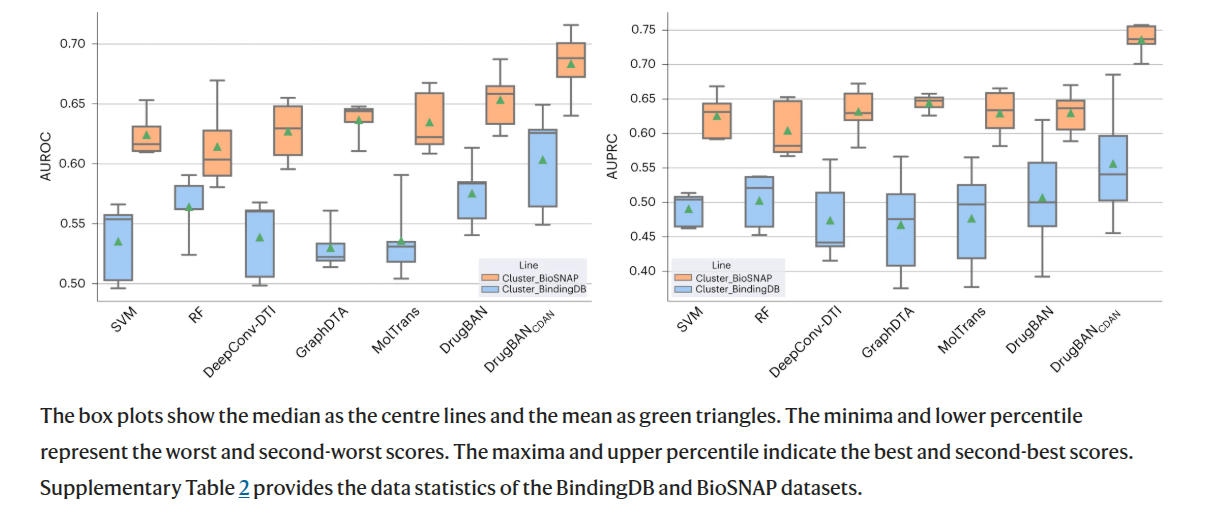

## Summary

In this tutorial, you learned how to use the **PyKale** library to build and evaluate a deep learning model for drug–target interaction (DTI) prediction.

We walked through the pipeline in three key steps:

### 1. Data Overview  
You explored how to load and prepare drug and protein data using PyKale’s data handling tools.

### 2. Model and Trainer Overview  
You saw how to configure and use the **DrugBAN** model with PyKale. You also learned how PyKale’s trainer simplifies the training process, including logging and model saving.

### 3. Training and Testing Overview  
You trained the model and evaluated its performance using commonly used metrics such as **AUROC**, **F1 score**, **recall**, and **specificity**.

---

This notebook is designed as an accessible entry point for researchers who are new to Python or machine learning, and who want to explore how graph-based deep learning can be applied to biomedical problems.

> 🧠 Tip: Try experimenting with the dataset, changing model settings, or applying PyKale to a new task. That’s the best way to learn!

For more information, check out the [original DrugBAN codebase](https://github.com/peizhenbai/DrugBAN) and the full paper in *Nature Machine Intelligence*.


### Explore More: 3 Tasks to Try (~1 Hour Total)

These tasks are designed to help you go beyond the tutorial and gain deeper, hands-on experience with model development, interpretation, and dataset handling. You don’t need prior experience in machine learning — just curiosity!

### 🔁 Task 1: Use the BindingDB Dataset (20 minutes)

Swap the current dataset with **BindingDB**, a real-world dataset containing experimentally measured drug–target interactions.

Steps:
1. Download or prepare the BindingDB dataset (if needed).
2. Update the  `data` fields in the YAML config file.
3. Reload the dataset and re-run training and testing.

**What to explore:**
- Does model performance change?
- Is the dataset more imbalanced?
- How does training time compare?

> Tip: See if the model struggles more or less with the new dataset. It can reveal how generalisable DrugBAN is.



### 🧪 Task 2: Inspect Misclassified Samples (20 minutes)

Dive into the test results and check where the model made incorrect predictions.  
This helps you understand where the model struggles and whether those mistakes make sense.

---

#### ✅ Steps

1. After testing, collect predicted probabilities and the true labels.
2. Print out the predictions that the model got wrong.
3. (Optional) Visualise the drug or protein graph for those samples.

---

#### 🔍 What to Explore

- **Are the wrong predictions close to 0.5?**  
  If so, the model was unsure. This can help you identify borderline cases.

- **Are there more false positives or false negatives?**  
  This tells you whether the model is more likely to over-predict interactions or miss them.

- **Do certain types of drug–protein pairs seem harder to classify?**  
  For example, some proteins or drugs may always appear in misclassified samples. This could point to noisy or hard-to-learn examples.

---

#### 🧬 (Optional) Visualise the Graph of a Misclassified Sample

You can plot the structure of a drug or protein graph that the model got wrong.  
This helps you interpret what the model was seeing when it made the incorrect prediction.


### 🧠 Task 3: Change the Protein Encoder (20 minutes)

Explore how the model behaves when you change the way proteins are represented.  
This task helps you understand whether the model relies more on protein structure or other features when making predictions.

---

💡 Ideas to Try
Use one hot embedding instead of integer encoding.

Replace the protein graph with a flat vector input (e.g. sequence length, molecular weight, or hydrophobicity).


🔍 What to Observe
- Does model performance improve, stay the same, or get worse?

- Which metric changes the most — AUROC, F1 score, or recall?

- Does training take more time or less time with the new encoder?

